In [15]:
using FileIO
using Images
using Plots
using Statistics
using LsqFit
using Clustering
using Profile
include("tiffxml.jl")

embedxml

In [2]:
data_dir = "/datahub/rawdata/tandeng/mRNA_imaging/mRNA_confocal_hamamatsu-60X-TIRF/20200316_result"
#cell_name = filter(x->occursin(r"^s",x), readdir(data_dir) )
cell_name = filter(x->occursin(r"^s[0-9][0-9]?-c[0-9][0-9]?.tiff-clear.ome.tiff$",x), readdir(data_dir) );

In [ ]:
nucleus_nor = zeros(700, 700, 136*20)
mini_all = zeros(136)
mean_all = zeros(136)
median_all = zeros(136)
for t in 1:136
    nozeros_raw = [real(i) for i in nucleus_img[14][1:700, 1:700, (t-1)*20+1:20*t] if i>0]
    nozeros = ( nozeros_raw .- minimum(nozeros_raw) )./(mean(nozeros_raw)-minimum(nozeros_raw)).*0.1 .+ 0.01
    mini_all[t] = minimum(nozeros_raw)
    mean_all[t] = mean(nozeros_raw )
    median_all[t] = median(nozeros_raw)
    #nucleus_nor[:, :,  (t-1)*20+1:20*t ] = (( nucleus_img[14][1:700, 1:700, (t-1)*20+1:20*t] 
    #    .- minimum(nozeros_raw) )./(mean(nozeros_raw)-minimum(nozeros_raw)).*0.1 .+ 0.01) .* ( nucleus_img[14][1:700, 1:700, (t-1)*20+1:20*t] .>0 )
    print("$t ")
end

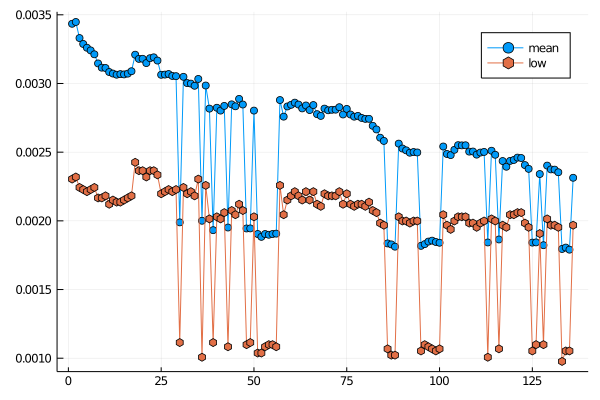

In [171]:
plot(mean_all, marker=(:dot), label="mean")
plot!(mini_all, marker=(:hex), label="low")
#plot!(median_all, marker=(:star), label="median")

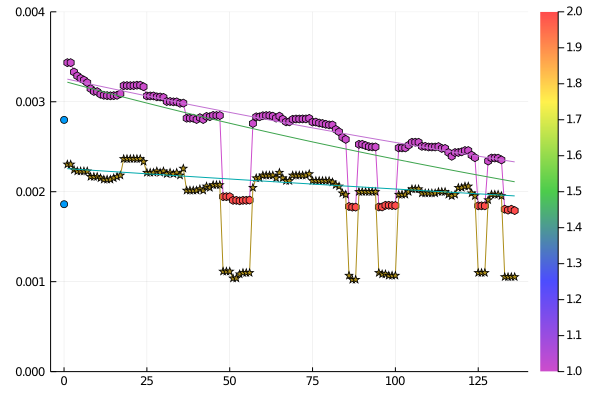

In [520]:
X = zeros(2, 136)
mean_all_med = medianfilter(mean_all, 3)
mini_all_med = medianfilter(mini_all, 3)
X[1, :] = fill(0.02, 136)
X[2, :] = mean_all_med;
result = kmeans(X, 2; init=:kmpp)
scatter(result.centers[1, :], result.centers[2, :], marker=(:dot))
plot!(mean_all_med, marker=(:hex), marker_z = result.assignments, color=:lightrainbow, leg=false)
plot!(ylim=(0, 0.004))
plot!(ydata)
if result.counts[1]> result.counts[2]
    index = 1
else
    index = 2
end
mean_all_med_nooutliers = [ mean_all_med[i]  for i in 1:135  if result.assignments[i] == index ]
mini_all_med_nooutliers = [ mini_all_med[i]  for i in 1:135  if result.assignments[i] == index ]
mean_all_med_nooutliers_x = [ i  for i in 1:135  if result.assignments[i] == index ];
fit_mean = curve_fit(model, mean_all_med_nooutliers_x, mean_all_med_nooutliers, [0.003, 0.0003])
fit_mini = curve_fit(model, mean_all_med_nooutliers_x, mini_all_med_nooutliers, [0.002, 0.0003])
mean_nooutliers = model(1:136, fit_mean.param)
mini_nooutliers = model(1:136, fit_mini.param)
plot!(mean_nooutliers)
plot!(mini_all_med, marker=(:star))
plot!(mini_nooutliers)

In [393]:
@. model(x, p) = p[1]*exp(-x*p[2]) 

model (generic function with 1 method)

In [506]:
for t in 1:136
    nucleus_nor[:, :,  (t-1)*20+1:20*t ] = (( nucleus_img[14][1:700, 1:700, (t-1)*20+1:20*t] 
        .- mini_nooutliers[t] )./(mean_nooutliers[t]-mini_nooutliers[t]).*0.1 .+ 0.01) .* ( nucleus_img[14][1:700, 1:700, (t-1)*20+1:20*t] .>0 )
end

In [71]:
"""
Extract feature from image
"""
function extract_feature(imgs)
    z_depth = 20
    t_len = size(imgs)[3] ÷ z_depth
    low_line = zeros(t_len)
    mean_line  = zeros(t_len)
    for t in 1:t_len
        nozeros_pixel = [real(i) for i in imgs[1:700, 1:700, (t-1)*20+1:20*t] if i ≠ 0]
        low_line[t] = minimum(nozeros_pixel)
        mean_line[t] = mean(nozeros_pixel)
    end
    low_line, mean_line
end

medianfilter1(v, ws) = [median(v[i:(i+ws-1)]) for i=1:(length(v)-ws+1) ]
medianfilter(v, ws) = medianfilter1(vcat(0,v,0),ws)

"""
Removing outliers and smoothing feature
"""
function correct_feature( low_line, mean_line )
    t_len = length(low_line)
    ws = 3 # use small window to remove spark
    low_line = medianfilter(low_line, ws)
    mean_line = medianfilter(mean_line, ws)
    
    X = zeros(2, t_len)
    X[1, :] = fill(0.02, t_len)
    X[2, :] = mean_line;
    result = kmeans(X, 2; init=:kmpp)
    if result.counts[1]> result.counts[2]
        index = 1
    else
        index = 2
    end
    mean_line_nooutliers = [ mean_line[i]  for i in 1:135  if result.assignments[i] == index ]
    low_line_nooutliers = [ low_line[i]  for i in 1:135  if result.assignments[i] == index ]
    t_line_nooutliers = [ i  for i in 1:135  if result.assignments[i] == index ]
    @. model(x, p) = p[1]*exp(-x*p[2]) # fit with expontional function
    fit_mean = curve_fit(model, t_line_nooutliers, mean_line_nooutliers, [0.003, 0.0003])
    fit_low = curve_fit(model, t_line_nooutliers, low_line_nooutliers, [0.002, 0.0003])
    corrected_mean_line = model(1:t_len, fit_mean.param)
    corrected_low_line = model(1:t_len, fit_low.param)
    
    corrected_low_line, corrected_mean_line
end

function normalize(imgs)
    z_depth = 20
    t_len = size(imgs)[3] ÷ z_depth
    d1_len, d2_len  = size(imgs)[1],  size(imgs)[2]
    low_line, mean_line = extract_feature(imgs)
    corrected_low_line, corrected_mean_line = correct_feature(low_line, mean_line)
    imgs_norm = zeros(size(imgs))
    
    for t in 1:t_len
        imgs_norm[:,:,(t-1)*20+1:20*t] = ((imgs[:,:,(t-1)*20+1:20*t] .- corrected_low_line[t]) ./ (corrected_mean_line[t]-corrected_low_line[t]).*0.005 .+ 0.02) .* ( imgs[:, :, (t-1)*20+1:20*t] .>0)
        print("$t ")
    end
    
    imgs_norm, corrected_low_line, corrected_mean_line
end

normalize (generic function with 1 method)

In [78]:
std(mean_line[1:end-1].-mean_line[2:end]), std(mean_line_raw[1:end-1].-mean_line_raw[2:end])

(6.563947088245149e-7, 0.00034875293294533814)

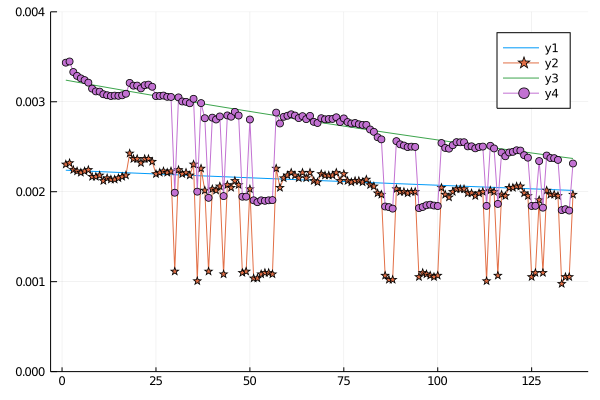

In [49]:
@time s14c1 = load(File(format"TIFF", "$data_dir/$(cell_name[14])"));
@time imgs_norm, low_line, mean_line = normalize(s14c1);
plot(low_line)
plot!(low_line_raw, marker=(:star))
plot!(mean_line)
plot!(mean_line_raw, marker=(:dot))
plot!(ylim=(0,0.004))

In [70]:
@time save(File(format"TIFF", "s24-c1-normalization-3.ome.tif"), N0f16.(imgs_norm .* ( 0 .< imgs_norm .< 1)))
@time embedxml(700, 700, 20, 136, "s24-c1-normalization-3.ome.tif")

 56.078879 seconds (3.67 M allocations: 7.766 GiB, 2.43% gc time)
Embedding OME-XML    1 image files updated
 14.514405 seconds (611.48 k allocations: 28.770 MiB, 0.09% gc time)


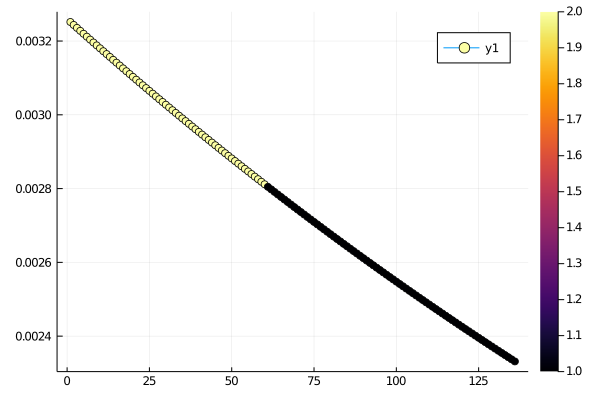

In [76]:
t_len = 136
X = zeros(2, t_len)
X[1, :] = fill(0.02, t_len)
X[2, :] = mean_line;
result = kmeans(X, 2; init=:kmpp)
plot(mean_line, marker_z = result.assignments ,marker=(:dot))